## Preamble

In [ ]:
# Import packages:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib.ticker import FuncFormatter, MultipleLocator
from pandas_datareader import data as pdr     
from pathlib import Path

# Import custom functions:
from aux_functions import *
from CallReports import CallReports
from mappings import mappings

# ignore warnings:
warnings.simplefilter("ignore", pd.errors.SettingWithCopyWarning)

# Set the theme for plots
sns.set_theme(
    style   ="whitegrid",   # light grid behind the bars
    palette ="pastel"       # soft default colours
)
# Set serif font for plots
plt.rcParams['font.family'] = 'serif'

In [ ]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'

In [ ]:
# Import information on IDRSSD and Charter Type:
att_closed = pd.read_csv(f'{path}/CSV_ATTRIBUTES_CLOSED.csv', low_memory=False)
att_active = pd.read_csv(f'{path}/CSV_ATTRIBUTES_ACTIVE.csv', low_memory=False)

att_active.rename(columns={'#ID_RSSD': 'IDRSSD', 
                           'CHTR_TYPE_CD': 'Charter Type'}, inplace=True)
att_active = att_active[['IDRSSD', 'Charter Type']]

att_closed.rename(columns={'#ID_RSSD': 'IDRSSD', 
                           'CHTR_TYPE_CD': 'Charter Type'}, inplace=True)
att_closed = att_closed[['IDRSSD', 'Charter Type']]

# merge att_closed and att_active:
att = pd.concat([att_closed, att_active])

# Keep only commercial banks:
commercial_banks = att[att['Charter Type']==200]['IDRSSD'].unique()


In [ ]:
# load DFF.csv file:
rates = pd.read_csv(f'{path}/DFF.csv', low_memory=False)
rates.rename(columns={'observation_date': 'Date', 'DFF':'FedFunds Rate'}, inplace=True)

# Convert 'Date' to datetime format:
rates['Date'] = pd.to_datetime(rates['Date'], format='%Y-%m-%d')
rates['Date'] = rates['Date'] - pd.Timedelta(days=1)
rates['FedFunds Rate'] = rates['FedFunds Rate']/100

In [ ]:
cr = CallReports(path)

In [ ]:
# define maturity variables:
loans_mat_vars = [
                'RCONA564', 'RCONA565', 'RCONA566', 'RCONA567', 'RCONA568', 'RCONA569',     # used
                #'RCFDA564', 'RCFDA565', 'RCFDA566', 'RCFDA567', 'RCFDA568', 'RCFDA569',     # to be tested
                # ------------------------------------------------------------------------------------------------
                'RCFDA570', 'RCFDA571', 'RCFDA572', 'RCFDA573', 'RCFDA574', 'RCFDA575',     # used 
                #'RCONA570', 'RCONA571', 'RCONA572', 'RCONA573', 'RCONA574', 'RCONA575',     # to be tested  
                ]

securities_mat_vars = [
             # --------------------------------------  Treasuries  --------------------------------------
                'RCFDA549', 'RCFDA550', 'RCFDA551', 'RCFDA552', 'RCFDA553', 'RCFDA554',     # used
                'RCONA549', 'RCONA550', 'RCONA551', 'RCONA552', 'RCONA553', 'RCONA554',     # to be tested
            # --------------------------------------  MBS  --------------------------------------
                'RCFDA555', 'RCFDA556', 'RCFDA557', 'RCFDA558', 'RCFDA559', 'RCFDA560',     # used
                'RCONA555', 'RCONA556', 'RCONA557', 'RCONA558', 'RCONA559', 'RCONA560',     # to be tested
                ]


# define the list of variables that will be used
vars = [
             # ------------------------------------------------------------------------------------------------ 
             'Date', 'IDRSSD', 'Financial Institution Name',            # Identifier Variables
             # ------------------------------------------------------------------------------------------------
            'RCON2170', 'RCFD2170',                                     # Total Assets
            'RCON3368', 'RCFD3368',                                     # QA Total Assets
             # ------------------------------------------------------------------------------------------------
             'RCON2122', 'RCFD2122',                                    # Total Loans
             # ------------------------------------------------------------------------------------------------
             'RCON2200',                                                # Total Deposits
             'RCON2215',                                                # Transaction Deposits
             'RCON6648',                                                # 0-100k
             'RCON2604',                                                # 100k+ (old)
             'RCONJ473',                                                # 100-250k (new)
             'RCONJ474',                                                # 250k+ (new)
             # ------------------------------------------------------------------------------------------------
             'RCONF045', 'RCONF046', 'RCONF047', 
             'RCONF048', 'RCONF049', 'RCONF050',
             'RCONF051', 'RCONF052', 'RCON3645',                        # Uninsured Deposits
             # ------------------------------------------------------------------------------------------------
             'RCON3210', 'RCFD3210',                                    # Total Equity Capital
             'RCONB530', 'RCFDB530',                                    # AOCI
             # ------------------------------------------------------------------------------------------------
             'RCON1754', 'RCFD1754',                                    # HTM Securities Ammortized Cost
             'RCFD1754_x', 'RCFD1754_y', 'RCON1754_x', 'RCON1754_y',
             # ------------------------------------------------------------------------------------------------
             'RCON1771', 'RCFD1771',                                    # HTM Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCON1772', 'RCFD1772',                                    # AFS Securities Ammortized Cost
             # ------------------------------------------------------------------------------------------------
             'RCONJJ34', 'RCFDJJ34',                                    
             'RCONJA22', 'RCFDJA22',                                    # Booked Securities
             # ------------------------------------------------------------------------------------------------
             'RCFD1773_x', 'RCFD1773_y', 'RCON1773',                    # AFS Securities Fair Value
             # ------------------------------------------------------------------------------------------------
             'RCONB987',                                                # FF sold in domestic offices
             'RCONB989', 'RCFDB989',                                    # Resell agreements                                  
             # ------------------------------------------------------------------------------------------------
             'RCFD0081', 'RCON0081',                                    # Cash and Balances Due from Depository Institutions
             'RCFD0071', 'RCON0071',
             'RCFD0010', 'RCON0010',
             # ------------------------------------------------------------------------------------------------
             'RIAD4508',                                                 # Interest Expenses
             'RIADA517', 'RIADA518', 'RIAD0093',
             'RIADHK03', 'RIADHK04', 'RIAD4073', 'RIAD4200', 'RIAD4185', 
             'RIAD4180', 'RIAD4172', 'RIAD4107', 'RIAD4340', 'RIAD4093'
             ] 

# create a list putting together 'vars', 'loans_mat_vars', and 'securities_mat_vars':
all_vars = vars + loans_mat_vars + securities_mat_vars

In [ ]:
main = cr.select_variables(all_vars)

In [ ]:
# Create all the new variables:
main = cr.construct_definitions(mappings=mappings)

In [ ]:
# keep only commercial banks:
main = main[main['IDRSSD'].isin(commercial_banks)]

In [ ]:
# merge main with rates per 'Date':
main = pd.merge(main, rates, on='Date', how='left')

In [ ]:
# Create 'Insured Deposit Accounts' and 'Number of Insured Deposit Accounts'
main['Insured Deposit Accounts'] = main['RCONF045'] + main['RCONF049']
main['Number of Insured Deposit Accounts'] = main['RCONF046'] + main['RCONF050']

# Create 'Uninsured Deposit Accounts' and 'Number of Uninsured Deposit Accounts'
main['Uninsured Deposit Accounts'] = main['RCONF047'] + main['RCONF051']
main['Number of Uninsured Deposit Accounts'] = main['RCONF048'] + main['RCONF052']

# Correct insurance coverage threshold based on date:
main['Insurance Coverage'] = np.where(main['Date'] < pd.Timestamp('2010-03-01'), 100, 250)

# Recalculate 'Insured Deposits' considering coverage threshold:
main['Insured Deposits'] = (
    main['Insured Deposit Accounts'] +
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Recalculate 'Uninsured Deposits':
main['Uninsured Deposits'] = (
    main['Uninsured Deposit Accounts'] -
    main['Number of Uninsured Deposit Accounts'] * main['Insurance Coverage']
)

# Create 'Total Deposits 2':
main['Total Deposits 2'] = main['Insured Deposits'] + main['Uninsured Deposits']

In [ ]:
# Recompute 'Time Deposits Expenses' considering that it accumulates over 'Year'. We want expenses per 'Date'. Use 
# groupby(['IDRSSD, 'Year']):
main['Time Deposit Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Time Deposit Expenses']
    .diff().fillna(main['Time Deposit Expenses'])
)

# Do the same for 'Transaction Deposit Expenses':
main['Transaction Deposit Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Transaction Deposit Expenses']
    .diff().fillna(main['Transaction Deposit Expenses'])
)

# Do the same for 'Savings Expenses':
main['Savings Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Savings Expenses']
    .diff().fillna(main['Savings Expenses'])
)

# Do the same for 'Interest Expenses on Subordinated Debt':
main['Interest Expenses on Subordinated Debt'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on Subordinated Debt']
    .diff().fillna(main['Interest Expenses on Subordinated Debt'])
)

# Do the same for 'Interest Expenses on FFS':
main['Interest Expenses on FFS'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on FFS']
    .diff().fillna(main['Interest Expenses on FFS'])
)

# Do the same for 'Interest Expenses on Foreign Deposits':
main['Interest Expenses on Foreign Deposits'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Interest Expenses on Foreign Deposits']
    .diff().fillna(main['Interest Expenses on Foreign Deposits'])
)

# Do the same for 'Total Interest Expenses':
main['Total Interest Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Total Interest Expenses']
    .diff().fillna(main['Total Interest Expenses'])
)

# Do the same for 'Total Interest Income':
main['Total Interest Income'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Total Interest Income']
    .diff().fillna(main['Total Interest Income'])
)

# Do the same for 'Net Interest Income':
main['Net Interest Income'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Net Interest Income']
    .diff().fillna(main['Net Interest Income'])
)

# Create 'Deposit Expenses' as the sum of all deposit expenses:
main['Deposit Expenses'] = (
    main['Transaction Deposit Expenses'] +
    main['Savings Expenses'] +
    main['Time Deposit Expenses']
)

# Compute 'Deposit Expenses 2':
main['Deposit Expenses 2'] = (
    main['Total Interest Expenses'].fillna(0) - main['Interest Expenses on Subordinated Debt'].fillna(0) - 
    main['Other Interest Expenses'].fillna(0) - main['Interest Expenses on FFS'].fillna(0) - 
    main['Interest Expenses on Foreign Deposits'].fillna(0)
)

main['Non Interest Expenses'] = (
    main.groupby(['IDRSSD', main['Date'].dt.year])['Non Interest Expenses']
    .diff().fillna(main['Non Interest Expenses'])
)

In [ ]:
# create 'Deposit Rates' as the ratio of 'Deposit Expenses' to 'Total Deposits':
main['Deposit Rates'] = main['Deposit Expenses'] / main['Total Deposits']
# mask negative values:
main['Deposit Rates'] = main['Deposit Rates'].mask(main['Deposit Rates'] <= 0, np.nan)

main['Deposit Rates 2'] = main['Deposit Expenses 2'] / main['Total Deposits']
# mask negative values:
main['Deposit Rates 2'] = main['Deposit Rates 2'].mask(main['Deposit Rates 2'] <= 0, np.nan)

In [ ]:
# Create the new variables:
main['Total Securities'] = main['HTM Securities'].fillna(0) + main['AFS Securities'].fillna(0) + main['Equity Securities'].fillna(0)
main['Securities per Assets'] = main['Total Securities'] / main['Total Assets']
main['Securities and FFS per Asset'] = (main['Total Securities'] + main['FFS']) / main['Total Assets']
main['Cash, Securities and FFS per Asset'] = (main['Cash'] + main['Total Securities'] + main['FFS']) / main['Total Assets']
main['Cash per Asset'] = main['Cash'] / main['Total Assets']
# mask shares that are negative or greater than 1:
main['Securities per Assets'] = main['Securities per Assets'].mask(main['Securities per Assets'] < 0, np.nan)
main['Securities per Assets'] = main['Securities per Assets'].mask(main['Securities per Assets'] > 1, np.nan)
main['Securities and FFS per Asset'] = main['Securities and FFS per Asset'].mask(main['Securities and FFS per Asset'] < 0, np.nan)
main['Securities and FFS per Asset'] = main['Securities and FFS per Asset'].mask(main['Securities and FFS per Asset'] > 1, np.nan)
main['Cash, Securities and FFS per Asset'] = main['Cash, Securities and FFS per Asset'].mask(main['Cash, Securities and FFS per Asset'] < 0, np.nan)
main['Cash, Securities and FFS per Asset'] = main['Cash, Securities and FFS per Asset'].mask(main['Cash, Securities and FFS per Asset'] > 1, np.nan)
main['Cash per Asset'] = main['Cash per Asset'].mask(main['Cash per Asset'] < 0, np.nan)
main['Cash per Asset'] = main['Cash per Asset'].mask(main['Cash per Asset'] > 1, np.nan)

# Create 'Interest Expenses Rate' as the ratio of expenses and Total Assets, mask the negatives
main['Interest Expenses Rate'] = 4* main['Total Interest Expenses'] / main['QA Total Assets']
main['Interest Expenses Rate'] = main['Interest Expenses Rate'].mask(main['Interest Expenses Rate'] < 0, np.nan)

# Create 'Interest Income Rate' as the ratio of income and Total Assets, mask the negatives:
main['Interest Income Rate'] = 4* main['Total Interest Income'] / main['QA Total Assets']
main['Interest Income Rate'] = main['Interest Income Rate'].mask(main['Interest Income Rate'] < 0, np.nan)

# Create 'Deposit Expenses Rate' as the ratio of expenses and Total Assets, mask the negatives:
main['Deposit Expenses Rate'] = 4* main['Deposit Expenses 2'] / main['QA Total Assets']
main['Deposit Expenses Rate'] = main['Deposit Expenses Rate'].mask(main['Deposit Expenses Rate'] < 0, np.nan)

# Create 'Non Interest Expenses Rate' as the ratio of Non Interest Expenses and Total Assets, mask the negatives:
main['Non Interest Expenses Rate'] = 4* main['Non Interest Expenses'] / main['QA Total Assets']
main['Non Interest Expenses Rate'] = main['Non Interest Expenses Rate'].mask(main['Non Interest Expenses Rate'] < 0, np.nan)

# Create 'Return on Assets' as the ratio of Net Interest Income and Total Assets, mask the negatives:
main['Return on Assets'] = 4* main['Net Interest Income'] / main['QA Total Assets']
main['Return on Assets'] = main['Return on Assets'].mask(main['Return on Assets'] < 0, np.nan)

# Create 'NIM' as the difference between 'Interest Income Rate' and 'Interest Expenses Rate':
main['NIM'] = main['Interest Income Rate'] - main['Interest Expenses Rate']

# Create 'Leverage Ratio' as the ratio of Total Assets and Total Equity Capital:
main['Leverage Ratio'] = main['Total Assets'] / main['Total Equity Capital']
main['Leverage Ratio'] = main['Leverage Ratio'].mask(main['Leverage Ratio'] < 0, np.nan)

In [ ]:
# create the 'Treasury Maturity' variable:

main['Treasury Maturity'] = ((
                            main['Treasuries (3M-)']*1.5 + 
                            main['Treasuries (3M-1Y)']*7.5 + 
                            main['Treasuries (1Y-3Y)']*24 + 
                            main['Treasuries (3Y-5Y)']*48 + 
                            main['Treasuries (5Y-15Y)']*120 + 
                            main['Treasuries (15Y+)']*180
                            ) / (
                                main['Treasuries (3M-)']        + 
                                main['Treasuries (3M-1Y)']      + 
                                main['Treasuries (1Y-3Y)']      + 
                                main['Treasuries (3Y-5Y)']      + 
                                main['Treasuries (5Y-15Y)']     + 
                                main['Treasuries (15Y+)']
                            )) / 12

print(main['Treasury Maturity'].describe())

# create the 'MBS Maturity' variable:
main['MBS Maturity'] = ((
                            main['MBS (3M-)']*1.5 + 
                            main['MBS (3M-1Y)']*7.5 + 
                            main['MBS (1Y-3Y)']*24 + 
                            main['MBS (3Y-5Y)']*48 + 
                            main['MBS (5Y-15Y)']*120 + 
                            main['MBS (15Y+)']*180
                            ) / (
                                main['MBS (3M-)']        + 
                                main['MBS (3M-1Y)']      + 
                                main['MBS (1Y-3Y)']      + 
                                main['MBS (3Y-5Y)']      + 
                                main['MBS (5Y-15Y)']     + 
                                main['MBS (15Y+)']
                            )) / 12
print(main['MBS Maturity'].describe())

# create the 'Security Maturity' variable:
main['Security Maturity'] = ((
                            main['Securities (3M-)']*1.5 + 
                            main['Securities (3M-1Y)']*7.5 + 
                            main['Securities (1Y-3Y)']*24 + 
                            main['Securities (3Y-5Y)']*48 + 
                            main['Securities (5Y-15Y)']*120 + 
                            main['Securities (15Y+)']*180
                            ) / (
                                main['Securities (3M-)']        + 
                                main['Securities (3M-1Y)']      + 
                                main['Securities (1Y-3Y)']      + 
                                main['Securities (3Y-5Y)']      + 
                                main['Securities (5Y-15Y)']     + 
                                main['Securities (15Y+)']
                            )) / 12

print(main['Security Maturity'].describe())

In [ ]:
main['High Rates'] = main['FedFunds Rate'] > main['FedFunds Rate'].quantile(0.5)

## Dreschler et. al (2021)

In [ ]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 'Total Interest Income', 'Total Interest Expenses',
           'Interest Expenses on Subordinated Debt', 'Other Interest Expenses', 'Interest Expenses on FFS',
           'Interest Expenses on Foreign Deposits', 'Deposit Expenses', 'Deposit Expenses 2', 'Deposit Rates',
           'Deposit Rates 2', 'Total Deposits', 'Total Deposits 2', 'Insured Deposits', 'Uninsured Deposits',
           'Total Assets', 'HTM Securities', 'AFS Securities', 'Equity Securities', 'FFS', 'Cash',
           'Transaction Deposits', 'Time Deposits', 'Time Deposit Expenses', 'Transaction Deposit Expenses',
           'Savings Expenses', 'Total Securities', 'Securities per Assets', 'Securities and FFS per Asset',
           'Cash, Securities and FFS per Asset', 'Cash per Asset', 'Return on Assets', 'NIM']]

In [ ]:
# use seaborn to plot 'Total Interest Income' and 'Total Interest Expenses':
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Date', y='Interest Income Rate', data=main, ax=ax, errorbar=None, ls='-.', lw=3)
sns.lineplot(x='Date', y='Interest Expenses Rate', data=main, ax=ax, errorbar=None, color='firebrick', lw=3)
sns.lineplot(x='Date', y='Deposit Expenses Rate', data=main, ax=ax, errorbar=None, lw=3, ls=':', color='black')
plt.legend(labels=['Total Interest Income', 'Total Interest Expenses', 'Deposit Expenses'])
plt.title('Total Interest Income and Total Interest Expenses')
plt.xlabel('Date')
plt.ylabel(None)
# put y-ticks every 0.04 units:
ax.yaxis.set_major_locator(MultipleLocator(0.04))
plt.ylim(0, 0.16)
plt.grid(True, linestyle=':', alpha=0.6, color='lightgray')
plt.show()

In [ ]:
# put two plots side by side, the one above and NIM with ROA:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='Date', y='Return on Assets', data=main, ax=ax, errorbar=None, ls='-.', lw=3)
sns.lineplot(x='Date', y='NIM', data=main, ax=ax, errorbar=None, ls='-', lw=3, color='firebrick')
plt.legend(labels=['ROA', 'NIM'])
plt.title('NIM and ROA')
plt.xlabel('Date')
plt.ylabel(None)
plt.ylim(0, 0.16)
plt.grid(True, linestyle=':', alpha=0.6, color='lightgray')
plt.show()

## Begenau et. al (2025)

In [ ]:
df = main[['Date', 'IDRSSD', 'Financial Institution Name', 
           'Total Assets', 'HTM Securities', 'AFS Securities', 'FFS', 'Equity Securities', 'Cash',
           'Transaction Deposits', 'Time Deposits', 'Time Deposit Expenses', 'Transaction Deposit Expenses', 
           'Cash, Securities and FFS per Asset', 'Cash per Asset', 'Securities per Assets', 'Securities and FFS per Asset',
           'Total Securities']]

In [ ]:
# Keep 2010Q1 to 2022Q4:
df = df[(df['Date'] >= '2010-01-01') & (df['Date'] <= '2022-12-31')]

In [ ]:
df['Log Total Assets'] = np.log(df['Total Assets'])

In [ ]:
# make a scatter plot of 'Cash, Securities and FFS per Asset' vs 'Total Assets' using seaborn:
plt.figure(figsize=(8, 6))
binned_scatter(df['Total Assets'], df['Cash, Securities and FFS per Asset'], q=100, marker='o', dispersion=False)
plt.axvline(x=.995, color='lightcoral', linestyle='--', label='99th Percentile of Total Assets')
plt.title('Cash, Securities and FFS per Asset vs Total Assets')
plt.tight_layout()
plt.show()

# make a scatter plot of 'Securities and FFS per Asset' vs 'Total Assets' using seaborn:
plt.figure(figsize=(8, 6))
binned_scatter(df['Total Assets'], df['Cash, Securities and FFS per Asset'], q=100, marker='o', dispersion=False, label='w/ cash')
binned_scatter(df['Total Assets'], df['Securities and FFS per Asset'], q=100, marker='s', dispersion=False, label='w/o cash', color='firebrick')
plt.legend()
plt.axvline(x=.995, color='lightcoral', linestyle='--', label='99th Percentile of Total Assets')
plt.title("Cross sectional distribution of banks' portfolios")
plt.legend(['w/ cash', 'w/o cash', '99th Percentile of Total Assets'])
plt.tight_layout()

## Silicon Valley Event Study 

In [ ]:
import yfinance as yf
import statsmodels.api as sm
import re

In [ ]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/replications/svb_event_study'

In [ ]:
tickers = [
    "ALLY",  # Ally Financial Inc.
    "AMTB",  # Amerant Bancorp Inc.
    "ABCB",  # Ameris Bancorp
    "ASB",   # Associated Banc-Corp
    "AUB",   # Atlantic Union Bankshares Corporation
    "AX",    # Axos Financial Inc.
    "BANC",  # Banc of California Inc.
    "BK",    # Bank of New York Mellon Corporation
    "BAC",   # Bank of America Corporation
    "BOH",   # Bank of Hawaii Corporation
    "BKU",   # BankUnited Inc.
    "BHB",   # Bar Harbor Bankshares Inc.
    "BHLB",  # Berkshire Hills Bancorp Inc.
    "BRBS",  # Blue Ridge Bankshares Inc.
    "CADE",  # Cadence Bank
    "COF",   # Capital One Financial Corporation
    "C",     # Citigroup Inc.
    "CFG",   # Citizens Financial Group Inc.
    "CMA",   # Comerica Incorporated
    "CFR",   # Cullen/Frost Bankers Inc. 
    "FNB",   # F.N.B. Corporation
    "FBK",   # FB Financial Corporation
    "FITB",  # Fifth Third Bancorp
    "HBAN",  # Huntington Bancshares Incorporated
    "KEY",   # KeyCorp
    "MTB",   # M&T Bank Corporation
    "PNC",   # PNC Financial Services Group Inc.
    "RF",    # Regions Financial Corporation
    "STT",   # State Street Corporation
    "SYF",   # Synchrony Financial
    "USB",   # U.S. Bancorp
    "WFC",   # Wells Fargo & Company
    "SCHW",  # Charles Schwab Corporation
    "AXP",   # American Express Company
    "DFS",   # Discover Financial Services
    "NTB",   # Bank of N.T. Butterfield & Son Limited
    "EWBC",  # East West Bancorp Inc.
    "WAL",   # Western Alliance Bancorporation
    "SSB",   # SouthState Corporation
    "WBS",   # Webster Financial Corporation
    "FHN",   # First Horizon Corporation
    "PNFP",  # Pinnacle Financial Partners Inc.
    "HOMB",  # Home BancShares Inc.
    "HTH",   # Hilltop Holdings Inc.
    "GBCI",  # Glacier Bancorp Inc.
    "BOKF",  # BOK Financial Corporation
    "ZION",  # Zions Bancorporation
    "TCBI",  # Texas Capital Bancshares Inc.
    "CIVB",  # Civista Bancshares Inc.
    "CFFI",  # C&F Financial Corporation
    "BANF",  # BancFirst Corporation
    "FULT",  # Fulton Financial Corporation
    "ONB",   # Old National Bancorp
    "PB",    # Prosperity Bancshares Inc.
    "UBSI",  # United Bankshares Inc.
    "VLY",   # Valley National Bancorp
    "TRMK",  # Trustmark Corporation 
    "CASH",  # Meta Financial Group Inc.
    "CUBI",  # Customers Bancorp Inc.
    "CFFN",  # Capitol Federal Financial Inc.
    "FFIN",  # First Financial Bankshares Inc. 
    "SFBS",  # ServisFirst Bancshares Inc.
    "TBBK",  # The Bancorp Inc. 
    "WSBC",  # WesBanco Inc.
    "WTFC",  # Wintrust Financial Corporation
]

In [ ]:
event_date = pd.Timestamp("2023-03-08")
event_window = pd.Timedelta(days=10)  
estimation_window = pd.Timedelta(days=500) 
start_date = event_date - event_window - estimation_window 

In [ ]:
# Download the tickers and rename columns to only retain ticker names
stock_data = yf.download(
    tickers, 
    start=start_date, 
    end=event_date + 4*event_window,
    progress=False,
)
stock_data = stock_data.iloc[:, 0:len(tickers)]
stock_data.columns = (
    stock_data.columns.map(lambda col: re.sub(r"[()\s']", "", col[1]))
)

# Calculate daily returns
returns = stock_data.pct_change().dropna()*100

# Read in FF 3 factor daily data
ff_path = path + '/fama-french-3.csv'
fama_french_data = pd.read_csv(ff_path).iloc[:, :-1]
# Read the Date column as a date and set it as the index
fama_french_data["Date"] = pd.to_datetime(
    fama_french_data["Date"], 
    format="%Y-%m-%d", 
)
fama_french_data = fama_french_data.set_index("Date")

# Merge returns and FF data, drop unnecessary data
merged_data = pd.concat(
    [returns, fama_french_data], 
    axis=1
).dropna(axis=0)

In [ ]:
# Create arrays to hold abnormal returns   
abnormal_returns_factor = pd.DataFrame()
abnormal_returns_mean = pd.DataFrame()    

# Estimate abnormal returns for each 
for ticker in tickers:
    # Estimate the 3-factor abnormal returns
    X = merged_data.loc[
        merged_data.index < event_date - event_window, 
        ["Mkt-RF", "SMB", "HML"]
    ]   
    y = merged_data.loc[
        merged_data.index < event_date - event_window, 
        ticker
    ] 
    X = sm.add_constant(X) 
    model = sm.OLS(y, X).fit()   

    # Compute expected returns during the window
    X_event = (
        merged_data.loc[
            ((merged_data.index >= event_date - event_window) & 
            (merged_data.index <= event_date + event_window)), 
            ["Mkt-RF", "SMB", "HML"]
        ]
    )
    X_event = sm.add_constant(X_event)
    expected_returns = model.predict(X_event)

    # Extract realized returns during the event
    event_data = (
        merged_data.loc[
            ((merged_data.index >= event_date - event_window) & 
            (merged_data.index <= event_date + event_window)), 
            ticker
        ]
    )

    # Abnormal returns are residuals
    abnormal_returns_factor[ticker] = event_data - expected_returns
    abnormal_returns_mean[ticker] = event_data - y.mean()

In [ ]:
# Create an array for day dummies
dummy_df = (
    pd.get_dummies(
        np.maximum(
            (abnormal_returns_mean.index - pd.to_datetime(event_date)).days+1, 
            0,
        ), 
        prefix='day',
    )
)

# Set the index again
dummy_df.index = abnormal_returns_factor.index
# Drop the column of days preceding the event
dummy_df = dummy_df.drop("day_0", axis=1)

# Melt abnormal returns data
ar_factor_long = abnormal_returns_factor.reset_index().melt(id_vars="Date")
ar_factor_long.head()

# Merge data
ar_factor_days = pd.merge(
    ar_factor_long, 
    dummy_df, 
    how='left', 
    left_on='Date', 
    right_index=True,
)
# Split into two
exog = ar_factor_days.filter(regex="day*", axis=1).astype('float64')
exog = sm.add_constant(exog)
endog = ar_factor_days.loc[:, "value"]

# View
ar_factor_days.head()

In [ ]:
factor_model = sm.OLS(endog, exog).fit(cov_type="HC0")
print(factor_model.summary())

In [ ]:
# Extract coefs and SEs of daily indicators
dummy_coefficients = factor_model.params.iloc[1:]  
dummy_cov_matrix = factor_model.cov_params().iloc[1:, 1:]  

# Compute the cumulative effects
cumulative_effects = dummy_coefficients.cumsum()

# Compute the standard errors of the cumulative effects
cumulative_se = np.zeros(len(cumulative_effects))
for t in range(1, len(cumulative_effects) + 1):
    # Create a vector of ones up to day t and zeros afterwards
    indicator_vector = np.concatenate(
        [np.ones(t), np.zeros(len(cumulative_effects) - t)]
    )

    # Compute the SE of the cumulative effect
    cumulative_se[t - 1] = np.sqrt(
        indicator_vector @ dummy_cov_matrix @ indicator_vector
    )

# Create a DataFrame to store the results
results = pd.DataFrame(
    {
        "Day": factor_model.params.index[1:].map(lambda x: x[4:]),
        "Cumulative Effect": cumulative_effects,
        "SE": cumulative_se,
    }
)

# Prepend day 0 as a reference
day0_df = pd.DataFrame(
    {
        "Day": 0,
        "Cumulative Effect": 0,
        "SE": 0,
    },
    index = np.array(['day_0'])
)
results = pd.concat([day0_df, results])

# Construct confidence intervals
results["ci_upper"] = results["Cumulative Effect"] + 1.96 * results["SE"]
results["ci_lower"] = results["Cumulative Effect"] - 1.96 * results["SE"]

# Set index
results.index = abnormal_returns_mean.index[6:]

# Print the results
print(results)

In [ ]:
# plot the cumulative effects with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(results.index, results["Cumulative Effect"], marker='o', label='Cumulative Effect', lw=3, color='navy')
plt.axhline(0, color='black', linestyle='--', lw=1, label='Zero Line')
plt.title('Cumulative Abnormal Returns Around the Event Date')
plt.xlabel('Days Relative to Event Date')
plt.ylabel('Cumulative Abnormal Returns (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':', alpha=0.6, color='lightgray')
plt.fill_between(
    results.index, 
    results["ci_lower"], 
    results["ci_upper"], 
    color='lightgray', 
    alpha=0.5, 
    label='95% Confidence Interval'
)
plt.show()

## Paul GP, et. al (2023)

In [66]:
import os
from pathlib import Path          # nicer, OS-agnostic paths
import numpy as np
import pandas as pd
from functools import reduce
import yfinance as yf
import csv

In [2]:
BASE_DIR = Path(
    r"C:/Users/angel/Documents/Economics/Research/Banking Project/replications/bank_returns"
)
os.chdir(BASE_DIR)

In [3]:
# --- 2. Analysis dates ------------------------------------------------------
date_list   = [pd.Timestamp("2023-03-17"),   # equivalent to R’s as.Date()
               pd.Timestamp("2023-05-25")]
early_date, late_date = date_list            # unpack first / second element

In [ ]:
# --- 3. Load data -----------------------------------------------------------
# 3a. PERMCO ↔ RSSDID cross-walk
permco_rssdid_xwalk = (
    pd.read_csv(BASE_DIR / "data" / "input" / "permco_rssdid_xwalk.csv", encoding_errors='ignore')
      .query("entity.notna()")
    )

# Write a .txt file with the unique PERMCO codes to be given to the WRDS. 
permcos = permco_rssdid_xwalk["permco"].dropna().astype(int).unique()

out_file = Path.cwd() / "data" / "input" / "permco_list.txt"
with open(out_file, "w") as f:
    for pc in permcos:
        f.write(f"{pc}\n")

print(f"Wrote {len(permcos)} PERMCO codes to {out_file}")

# 3b. WRDS – Compustat firm-level descriptors
wrds_compustat_data = pd.read_csv(
    BASE_DIR / "data" / "input" / "wrds_data.csv", encoding_errors='ignore'
)

wrds_compustat_data.rename(columns={'LPERMCO': 'permco'}, inplace=True)

In [ ]:
# --- 4. Build the working sample ------------------------------------------
#
#  • inner-join the cross-walk (Permco ↔ RSSDID) with your freshly-downloaded
#    WRDS securities file (Permco ↔ Ticker, etc.)
#  • keep only records whose ‘dt_end’ ≥ 30-Sep-2021
#  • drop the duplicate RSSDIDs called out in the authors’ note
#

# 1. Merge on PERMCO ---------------------------------
bank_sample = (
    permco_rssdid_xwalk                     # left table  (has ‘permco’, ‘entity’)
      .merge(
          wrds_compustat_data,              # right table (has ‘PERMCO’, ‘tic’, …)
          how="inner",
          on="permco",
          )
)

# make 'entity' an integer:
bank_sample['entity'] = bank_sample['entity'].astype(int)

# 2. Keep quarters from 2021-Q3 onward ---------------
#    ‘dt_end’ arrives as an 8-digit int (20210930).  We can compare as int,
#    or turn it into a timestamp if you prefer.
bank_sample = bank_sample[bank_sample["dt_end"] >= 20210930]

# 3. Drop the unwanted duplicates --------------------
#    • entity 497570  = Luther Burbank *subsidiary* RSSDID
#    • entity 3382332 = South Plains *stock plan* RSSDID
bank_sample = bank_sample[~bank_sample["entity"].isin([497570, 3382332])]

# Optional: reset the index so it’s clean
bank_sample = bank_sample.reset_index(drop=True)


In [ ]:
# --- 5. Load the 2021-Q4 Y-9C filing (Schedule BHCF) -----------------------
#
# • File comes from the FR Y-9C bulk download.
# • CARET (^) is the field delimiter used by the Fed’s flat files.
# • We read it into a pandas DataFrame called y9c_data_2022q4

y9c_data_2022q4 = pd.read_csv(
    BASE_DIR / "data" / "input" / "BHCF20221231.txt",
    sep="^",               # same as data.table::fread(..., sep = "^")
    engine="python",       # python engine handles quirky delimiters better
)

In [11]:
# --- 6. Enrich the 2021-Q4 Y-9C data and join to the bank sample ----------

# 6-A.  Derive balance-sheet building blocks -------------------------------
y9c_q4_aug = y9c_data_2022q4.copy()

# helper: quick numeric coercion (Fed flat files arrive as object/str)
to_num = lambda s: pd.to_numeric(s, errors="coerce")

# cash + securities buckets -------------------------------------------------
y9c_q4_aug["cash_securities"] = y9c_q4_aug[
    ["BHCK0081", "BHCK0395", "BHCK0397", "BHCKJJ34", "BHCK1773", "BHCKJA22"]
].apply(to_num).sum(axis=1, skipna=True)

y9c_q4_aug["cash"] = y9c_q4_aug[["BHCK0081", "BHCK0395", "BHCK0397"]] \
    .apply(to_num).sum(axis=1, skipna=True)

y9c_q4_aug["securities"] = y9c_q4_aug[["BHCKJJ34", "BHCK1773", "BHCKJA22"]] \
    .apply(to_num).sum(axis=1, skipna=True)

# core line items -----------------------------------------------------------
y9c_q4_aug["liabilties"]            = to_num(y9c_q4_aug["BHCK2948"])
y9c_q4_aug["dep_y9c"]               = y9c_q4_aug[["BHDM6631", "BHDM6636"]] \
                                        .apply(to_num).sum(axis=1, skipna=True)
y9c_q4_aug["nonperforming_loans"]   = y9c_q4_aug[["BHCK1407", "BHCK1403"]] \
                                        .apply(to_num).sum(axis=1, skipna=True)
y9c_q4_aug["total_loans"]           = y9c_q4_aug[["BHCK5369", "BHCKB528"]] \
                                        .apply(to_num).sum(axis=1, skipna=True)

# four-type deposit total (matches the authors’ as.numeric() + …) ----------
y9c_q4_aug["deposits"] = (
      to_num(y9c_q4_aug["BHDM6631"])
    + to_num(y9c_q4_aug["BHDM6636"])
    + to_num(y9c_q4_aug["BHFN6631"])
    + to_num(y9c_q4_aug["BHFN6636"])
)

# capital & ratios ----------------------------------------------------------
y9c_q4_aug["tier1_capital"] = to_num(y9c_q4_aug["BHCA8274"])
y9c_q4_aug["tier1capratio"] = (to_num(y9c_q4_aug["BHCA7206"])
                               .fillna(to_num(y9c_q4_aug["BHCW7206"])))

# HTM / AFS positions -------------------------------------------------------
y9c_q4_aug["htm"]                     = to_num(y9c_q4_aug["BHCKJJ34"])
y9c_q4_aug["htm_book"]                = to_num(y9c_q4_aug["BHCK1754"])
y9c_q4_aug["unrealized_htm_losses"]   = (
    to_num(y9c_q4_aug["BHCK1754"]) - to_num(y9c_q4_aug["BHCK1771"])
)
y9c_q4_aug["assets"]                  = to_num(y9c_q4_aug["BHCK2170"])
y9c_q4_aug["afs"]                     = to_num(y9c_q4_aug["BHCK1773"])

# keep only the columns the R script later references ----------------------
keep_cols = [
    "deposits", "tier1_capital", "BHCA8274", "cash_securities",
    "unrealized_htm_losses", "cash", "assets", "afs",
    "htm", "htm_book", "securities", "liabilties", "dep_y9c",
    "RSSD9001", "nonperforming_loans", "total_loans", "tier1capratio"
]
y9c_q4_aug = y9c_q4_aug[keep_cols]

# 6-B.  Merge with the earlier bank_sample ---------------------------------
bank_q4 = (
    bank_sample
      .merge(y9c_q4_aug, left_on="entity", right_on="RSSD9001", how="inner")
)

# 6-C.  Compute the ratios the paper tracks --------------------------------
bank_q4 = bank_q4.assign(
    htm_ratio                     = lambda df: df["htm"] / df["assets"],
    htm_ratio2                    = lambda df: df["htm"] / df["afs"],
    npl_ratio                     = lambda df: df["nonperforming_loans"] / df["total_loans"],
    unrealized_htm_losses_rat_book   = lambda df: df["unrealized_htm_losses"] / df["htm_book"],
    unrealized_htm_losses_rat_tier1  = lambda df: df["unrealized_htm_losses"] / df["tier1_capital"],
    liquid_asset_ratio            = lambda df: df["cash_securities"] / df["assets"],
    liquid_asset_ratio2           = lambda df: df["cash_securities"] / df["tier1_capital"],
    cash_asset_ratio              = lambda df: df["cash"] / df["assets"],
    securities_asset_ratio        = lambda df: df["securities"] / df["assets"],
    loans_asset_ratio             = lambda df: df["total_loans"] / df["assets"],
    deposits_liabilities_ratio    = lambda df: df["deposits"] / df["liabilties"],
)

# final clean-up: drop rows with missing total assets -----------------------
bank_q4 = bank_q4[bank_q4["assets"].notna()].reset_index(drop=True)

#! This cell can be done nicely with our dictionary ! 

In [ ]:
CALL_DIR = (
    BASE_DIR
    / "data"
    / "input"
    / "FFIEC CDR Call Bulk All Schedules 12312022"
)

# 1. List all .txt files in the directory (same as dir(..., pattern = ".txt"))
files = sorted(CALL_DIR.glob("*.txt"))

# 2. Read them and left-merge on IDRSSD, mimicking the R for-loop
def read_schedule(fp: Path) -> pd.DataFrame:
    """
    Read one FFIEC bulk Call-Report schedule.

    * 2022-Q4 files are TAB-delimited (`\t`) and Win-1252 encoded.
    * Some lines contain stray tabs inside quotes → need a tolerant parser.
    * If pyarrow is present, we use it (fast, streams well); otherwise the
      pure-Python engine.
    """
    try:
        df = pd.read_csv(
            fp,
            sep='\t',
            encoding='cp1252',  # Windows-1252 encoding
            low_memory=False,
        ).drop(index=0).reset_index(drop=True)
        df['IDRSSD'] = (
                        pd.to_numeric(df['IDRSSD'], errors='coerce')   # turns bad strings into NaN
                        .astype('Int64')                             # keeps missing as <NA>
                        )
        return df
    except pd.errors.ParserError as err:
        print(f'ParserError in {fp} -> {err}')
        # In this case, use csv.QUOTE_NONE
        df = pd.read_csv(
            fp,
            sep='\t',
            engine='python',  # use the Python engine for better error handling
            encoding='cp1252',  # Windows-1252 encoding
            quoting=csv.QUOTE_NONE,
        ).drop(index=0).reset_index(drop=True)
        # remove quotes from df:
        df = df.replace({'"': ''}, regex=True)
        # remove quotes from column names:
        df.columns = df.columns.str.replace('"', '', regex=False)
        df['IDRSSD'] = (
                        pd.to_numeric(df['IDRSSD'], errors='coerce')   # turns bad strings into NaN
                        .astype('Int64')                             # keeps missing as <NA>
                        )



# read the first file
call_report_data_vars = read_schedule(files[0])

# iteratively left-join the remaining 47 (R used files[2:48])
for fp in files[1:48]:
    if "NARR" in fp.name:       # ⟵ skip the trouble-maker
        continue
    call_report_data_vars = call_report_data_vars.merge(
        read_schedule(fp),
        on="IDRSSD",
        how="left",
        suffixes=("", "_y"),
        copy=False
    )

# ↪  call_report_data_vars now contains one wide row per RSSDID,
#    with every column that appears in any of the 48 schedules.

In [15]:
# --- 8. Build 2022-Q4 Call-Report subsample --------------------------------

# helper so we type less
num = lambda s: pd.to_numeric(s, errors="coerce")

# 8-A.  Derive the composite balance-sheet lines ---------------------------
cr_aug = call_report_data_vars.copy()

# cash ---------------------------------------------------------------------
cash_fd  = num(cr_aug["RCFD0081"]) + num(cr_aug["RCFD0071"])
cash_con = num(cr_aug["RCON0081"]) + num(cr_aug["RCON0071"])
cr_aug["cash"] = cash_fd.combine_first(cash_con)        # coalesce()

# securities ---------------------------------------------------------------
sec_fd  = num(cr_aug["RCFDJJ34"]) + num(cr_aug["RCFD1773"]) + num(cr_aug["RCFDJA22"])
sec_con = num(cr_aug["RCONJJ34"]) + num(cr_aug["RCON1773"]) + num(cr_aug["RCONJA22"])
cr_aug["securities"] = sec_fd.combine_first(sec_con)
cr_aug["cash_securities"] = cr_aug["cash"] + cr_aug["securities"]

# liabilities, NPLs, loans --------------------------------------------------
cr_aug["liabilties"] = num(cr_aug["RCFD2948"]).combine_first(num(cr_aug["RCON2948"]))

npl_fd  = num(cr_aug["RCFD1407"]) + num(cr_aug["RCFD1403"])
npl_con = num(cr_aug["RCON1407"]) + num(cr_aug["RCON1403"])
cr_aug["nonperforming_loans"] = npl_fd.combine_first(npl_con)

loan_fd  = num(cr_aug["RCFD5369"]) + num(cr_aug["RCFDB528"])
loan_con = num(cr_aug["RCON5369"]) + num(cr_aug["RCONB528"])
cr_aug["total_loans"] = loan_fd.combine_first(loan_con)

# HTM, AFS, assets, capital -------------------------------------------------
cr_aug["htm"]  = num(cr_aug["RCFDJJ34"]).combine_first(num(cr_aug["RCONJJ34"]))
cr_aug["htm_book"] = num(cr_aug["RCFD1754"]).combine_first(num(cr_aug["RCON1754"]))
cr_aug["unrealized_htm_losses"] = (
    num(cr_aug["RCFD1754"]).combine_first(num(cr_aug["RCON1754"]))
    - num(cr_aug["RCFD1771"]).combine_first(num(cr_aug["RCON1771"]))
)

cr_aug["assets"] = num(cr_aug["RCFD2170"]).combine_first(num(cr_aug["RCON2170"]))
cr_aug["tier1_capital"] = num(cr_aug["RCFA8274"]).combine_first(num(cr_aug["RCOA8274"]))
cr_aug["afs"] = num(cr_aug["RCFD1773"]).combine_first(num(cr_aug["RCON1773"]))

# keep only columns R code keeps -------------------------------------------
cr_keep = cr_aug[
    [
        "tier1_capital", "cash_securities", "unrealized_htm_losses",
        "cash", "assets", "afs", "htm", "htm_book", "securities",
        "liabilties", "IDRSSD", "nonperforming_loans", "total_loans"
    ]
]

# 8-B.  Merge with the bank-sample and compute ratios ----------------------
call_report_subsample_2022q4 = (
    bank_sample
      .query("dt_end >= 20210930")                 # ≥ 2021-Q3
      .merge(cr_keep, left_on="entity", right_on="IDRSSD", how="inner")
      .assign(
          htm_ratio                     = lambda df: df.htm / df.assets,
          htm_ratio2                    = lambda df: df.htm / df.afs,
          npl_ratio                     = lambda df: df.nonperforming_loans / df.total_loans,
          unrealized_htm_losses_rat_book  = lambda df: df.unrealized_htm_losses / df.htm_book,
          unrealized_htm_losses_rat_tier1 = lambda df: df.unrealized_htm_losses / df.tier1_capital,
          tier1capratio_cr              = lambda df: df.tier1_capital / df.assets,
          liquid_asset_ratio            = lambda df: df.cash_securities / df.assets,
          liquid_asset_ratio2           = lambda df: df.cash_securities / df.tier1_capital,
          cash_asset_ratio              = lambda df: df.cash / df.assets,
          securities_asset_ratio        = lambda df: df.securities / df.assets,
          loans_asset_ratio             = lambda df: df.total_loans / df.assets,
      )
      .loc[lambda df: df.assets.notna()]           # drop rows missing total assets
      .reset_index(drop=True)
)
#! This part can be done nicely with our dictionary! 


In [ ]:
# --- 9. FDIC subsidiary-parent roll-up ------------------------------------
# 9-A. Load the RSSD relationship file and keep only ‘live’ links ----------
rel_all = (
    pd.read_csv(
        BASE_DIR / "data" / "input" / "CSV_RELATIONSHIPS.csv",
        encoding="latin1",
        dtype=str          # keep everything as text first
    )
)

# Turn the yyyymmdd string into a Timestamp column
rel_all["DT_END"] = pd.to_datetime(rel_all["DT_END"], format="%Y%m%d", errors="coerce")

# Keep relationships that were still valid after 1 Jan 2023
rel_all = rel_all[rel_all["DT_END"] > "2023-01-01"]

# remove the '#' from the column names:
rel_all.columns = rel_all.columns.str.replace('#', '', regex=False)

rel_all['ID_RSSD_PARENT'] = rel_all['ID_RSSD_PARENT'].astype(int)
rel_all['ID_RSSD_OFFSPRING'] = rel_all['ID_RSSD_OFFSPRING'].astype(int)

# 9-B. Keep only the parents that are in our bank sample -------------------
relationship_data = (
    bank_sample[["entity"]]                       # parent RSSDIDs we care about
      .merge(rel_all,
             left_on="entity",                   # parent in bank_sample
             right_on="ID_RSSD_PARENT",          # parent in relationship file
             how="inner")
       .drop(columns='ID_RSSD_PARENT')  # drop the duplicate parent column
       .rename(columns={"entity": "ID_RSSD_PARENT"})   # match R’s `select(ID_RSSD_PARENT = entity, …)`
       .loc[:, ["ID_RSSD_PARENT", "ID_RSSD_OFFSPRING"]]
)

# 9-C. Add the convenience column `top_holder` -----------------------------
relationship_data["top_holder"] = relationship_data["ID_RSSD_PARENT"]

# --- 9-D.  Add the subsidiaries-of-subsidiaries ---------------------------

# 1. Take every OFFSPRING we already have and treat it as a new “parent”
child_relationship_data = (
    relationship_data
        .loc[:, ["ID_RSSD_OFFSPRING", "top_holder"]]        # keep the pair
        .rename(columns={"ID_RSSD_OFFSPRING": "entity"})    # tmp name to match merge key
        .merge(                                            # find its own children
            rel_all,                                       # the full live-relationship table
            left_on="entity", right_on="ID_RSSD_PARENT",
            how="inner"
        )
        .loc[:, ["ID_RSSD_OFFSPRING", "top_holder"]]       # final shape
)

# 2. Append the new rows to the one-level relationship table
relationship_data = pd.concat(
    [
        relationship_data.loc[:, ["top_holder", "ID_RSSD_OFFSPRING"]],
        child_relationship_data
    ],
    ignore_index=True
).drop_duplicates()

# -------------------------------------------------------------------------
# Build a complete charter-to-top_holder map by walking the hierarchy
# -------------------------------------------------------------------------

# relationship_data    <- contains the first two levels we already built
# rel_all              <- full, *live* parent-child table (DT_END > 2023-01-01)

working = relationship_data.copy()                           # start queue

for _ in range(25):                                           # depth limit
    # 1. use current offspring as new "parents"
    new_kids = (
        working[["ID_RSSD_OFFSPRING", "top_holder"]]
          .rename(columns={"ID_RSSD_OFFSPRING": "entity"})
          .merge(
              rel_all[["ID_RSSD_PARENT", "ID_RSSD_OFFSPRING"]],
              left_on="entity",
              right_on="ID_RSSD_PARENT",
              how="inner"
          )
          .loc[:, ["ID_RSSD_OFFSPRING", "top_holder"]]
    )

    # 2. append and de-duplicate
    before = len(relationship_data)
    relationship_data = (
        pd.concat(
            [relationship_data[["top_holder", "ID_RSSD_OFFSPRING"]], new_kids],
            ignore_index=True
        )
        .drop_duplicates()
    )

    # 3. stop early if we didn't find any new rows
    if len(relationship_data) == before:
        break

    # 4. next iteration searches children of the *new* kids
    working = new_kids

# After the loop -----------------------------------------------------------
# relationship_data now holds *every* charter-level RSSDID that rolls up
# to one of the top-holders in your study, regardless of ownership depth.

# assume `relationship_data` already has the child links
# and `bank_sample["entity"]` holds the list of top-holder RSSDIDs.

self_loops = (
    bank_sample[["entity"]]
      .rename(columns={"entity": "top_holder"})
      .assign(ID_RSSD_OFFSPRING=lambda df: df["top_holder"])
)

relationship_data = (
    pd.concat([relationship_data, self_loops], ignore_index=True)
      .drop_duplicates()          # avoid doubles if already present
)
# This guarantees that every top-holder's balances will also enter the group by sum alongside its subsidiaries.


In [41]:
# -------------------------------------------------------------------------
#* 10.  Call-Report data that maps FDIC certs to RSSD IDs 
#* (will be used to merge the Summary of Deposits data)
# -------------------------------------------------------------------------
# --- read the “active” charter file ---------------------------------------
attr_active = pd.read_csv(
    BASE_DIR / "data" / "input" / "CSV_ATTRIBUTES_ACTIVE.csv",
    usecols=["ID_FDIC_CERT", "#ID_RSSD"],
    encoding="latin1",   # FDIC files → Windows-1252
    dtype=str            # keep IDs as strings
)

# remove '#' from the column names:
attr_active.columns = attr_active.columns.str.replace('#', '', regex=False)

# --- read the “closed” charter file ---------------------------------------
attr_closed = pd.read_csv(
    BASE_DIR / "data" / "input" / "CSV_ATTRIBUTES_CLOSED.csv",
    usecols=["ID_FDIC_CERT", "#ID_RSSD"],
    encoding="latin1",
    dtype=str
)

attr_closed.columns = attr_closed.columns.str.replace('#', '', regex=False)

# --- stack them and drop any duplicates -----------------------------------
call_report_data = (
    pd.concat([attr_active, attr_closed], ignore_index=True)
      .drop_duplicates()
)

# Make 'ID_RSSD' an integer:
call_report_data['ID_RSSD'] = call_report_data['ID_RSSD'].astype(int)

# call_report_data now maps every FDIC certificate (active or closed)
# to its corresponding RSSD ID, ready for merges with NIC / Call-Report data.

# -------------------------------------------------------------------------
# 11.  Charter-level IDs that belong to one of our top-holder families
# -------------------------------------------------------------------------
children_cert_num = (
    call_report_data
        # keep only rows whose RSSD shows up as an "offspring" in the hierarchy
        .merge(
            relationship_data[["top_holder", "ID_RSSD_OFFSPRING"]],
            left_on="ID_RSSD",
            right_on="ID_RSSD_OFFSPRING",
            how="inner"
        )
        # keep / rename columns to mirror the R output
        .loc[:, ["ID_RSSD", "top_holder", "ID_FDIC_CERT"]]
        .rename(columns={
            "top_holder":      "ID_RSSD_PARENT",   # ultimate holding-company ID
            "ID_FDIC_CERT":    "fdic_cert_num"     # charter-level FDIC cert
        })
)

# ---------------------------------------------------------------------
# 12.  Save the charter-to-BHC map for FDIC queries
# ---------------------------------------------------------------------
out_path = BASE_DIR / "data" / "input" / "cert_nums.csv"

(children_cert_num
   .loc[children_cert_num["fdic_cert_num"].astype(str) != "0"]  # drop placeholder 0s
   .to_csv(out_path, index=False)
)


In [43]:
# ---------------------------------------------------------------------
# 13.  Import the Summary of Deposits data and merge with FDIC certs
# ---------------------------------------------------------------------


import requests
import json

# Get Institutions
banks_id = pd.read_csv("/Users/angel/Documents/Economics/Research/Banking Project/replications/bank_returns/data/input/cert_nums.csv")


# url= "https://banks.data.fdic.gov/api/institutions"

# params = dict(
#     search    = "NAME: Bank of Hawaii",
#     fields    = "NAME",
#     limit      = 10000,
#     )
# resp = requests.get(url=url, params = params)
# data = resp.json()
# data
# [data["data"][0]["data"][x] for x in ["NAME","CERT"]]

url= "https://banks.data.fdic.gov/api/financials"
output = [["CERT", "DEP", "DEPINS", "ASSETS"]]
for bank in banks_id['fdic_cert_num']:
    cert_num = int(bank)
    print(bank)
    params = dict(
        filters    = "CERT:%d" % cert_num,
        fields     = "CERT,REPDTE,ASSET,DEP,DEPINS",
        sort_by    = "REPDTE",
        sort_order = "DESC",
        limit      = 10000,
        offset     = 0,
        agg_term_fields = "REPDTE",
        agg_sum_fields  = "ASSET,DEP,DEPINS",
        agg_limit       = 1
    )
    resp = requests.get(url=url, params = params)
    data = resp.json()
    try:
        output.append([data["data"][0]["data"][x] for x in ["CERT","DEP","DEPINS", "ASSET"]])
    except:
        pass

bank_data_final = pd.DataFrame(output[1:], columns = ["CERT", "DEP", "DEPINS", "ASSETS"]).merge(right=banks_id, left_on = "CERT", right_on = "fdic_cert_num")

bank_data_final.to_csv("/Users/angel/Documents/Economics/Research/Banking Project/replications/bank_returns/data/input/bank_deposits.csv")

17266
110
29744
24045
10619
32203
90211
33539
34618
35095
57777
57944
57716
58481
58596
58140
58696
58513
7472
30836
19953
29058
24735
32232
11329
27332
27330
33702
34227
35483
57053
59017


In [56]:
# -------------------------------------------------------------------------
# 14.  Roll charter-level FDIC balances up to the holding-company level
#      and attach each BHC’s stock-market ticker
# -------------------------------------------------------------------------

# 1. Read the charter-level deposit & asset file you saved in step 13
fdic_deposit_data = pd.read_csv(
    BASE_DIR / "data" / "input" / "bank_deposits.csv",
    dtype={"ID_RSSD_PARENT": int}   # keep IDs as strings
)

# 2. Aggregate to the BHC (parent-RSSD) level
fdic_agg = (
    fdic_deposit_data
        .groupby("ID_RSSD_PARENT", as_index=False, sort=False)
        .agg(
            DEP      = ("DEP",     "sum"),    # total deposits
            DEPINS   = ("DEPINS",  "sum"),    # FDIC-insured deposits
            ASSETS_FDIC = ("ASSETS", "sum")   # total assets per FDIC
        )
)

# 3. Bring in the ticker symbol from `bank_sample`
fdic_agg = fdic_agg.merge(
    bank_sample[["entity", "tic"]],          # just the ID + ticker
    left_on="ID_RSSD_PARENT",
    right_on="entity",
    how="inner"                                 # keep only BHCs in sample
).drop(columns="entity")                       # entity is now redundant


In [59]:
# ---------------------------------------------------------------------
# 15.  Assemble the final, analysis-ready bank panel  (224 BHCs)
# ---------------------------------------------------------------------

# ── 15-A.  Stack the Y-9C and Call-Report balance-sheet snapshots ─────────
bank_balance_sheet_sample = pd.concat(
    [bank_q4,            # == y9c_data_2022q4_subsample  (BHC filings)
     call_report_subsample_2022q4],   # charter data rolled to BHC level
    ignore_index=True,
    sort=False
)

# Harmonise Tier-1-capital ratio
bank_balance_sheet_sample["tier1capratio"] = np.where(
    bank_balance_sheet_sample["tier1capratio"].notna(),           # Y-9C value exists?
    bank_balance_sheet_sample["tier1capratio"] / 100.0,           # → divide by 100
    bank_balance_sheet_sample["tier1capratio_cr"]                 # else use Call-Report ratio
)

# (optional) if a BHC appears twice, keep first occurrence
bank_balance_sheet_sample = bank_balance_sheet_sample.drop_duplicates(
    subset="tic", keep="first"
)

# ── 15-B.  Merge FDIC aggregates and create final variables ──────────────
# fdic_deposit_data comes from step 14 (called fdic_agg in earlier code)
final_bank_data = (
    fdic_agg                      # DEP, DEPINS, ASSETS_FDIC, TICKER
      .merge(bank_balance_sheet_sample,    # liquidity, HTM ratios, etc.
             on="tic", how="inner")     # keep only BHCs with BOTH sources
      .assign(
          # Use Fed total assets if present; otherwise FDIC’s figure
          assets_imp      = lambda df: df["assets"].combine_first(df["ASSETS_FDIC"]),
          # Share of *uninsured* deposits
          dep_unins_share = lambda df: 1 - (df["DEPINS"] / df["DEP"])
      )
)

# ── 15-C.  Export / keep ticker list for market-data pulls ───────────────
bank_data_ticker_list = final_bank_data["tic"].tolist()

# (If you want to save)
# final_bank_data.to_csv(BASE_DIR / "data" / "output" / "final_bank_panel.csv",
#                        index=False)


In [248]:
# ---------------------------------------------------------------------
# 16.  Pull daily close prices from Yahoo and prepare returns dataset
# ---------------------------------------------------------------------


# ── 16-A.  Choose the tickers and date window ──────────────────────────
# Drop "SI" up-front (Silvergate was wound down and excluded in the R code)
tickers = [
    "ALLY",  # Ally Financial Inc.
    "AMTB",  # Amerant Bancorp Inc.
    "ABCB",  # Ameris Bancorp
    "ASB",   # Associated Banc-Corp
    "AUB",   # Atlantic Union Bankshares Corporation
    "AX",    # Axos Financial Inc.
    "BANC",  # Banc of California Inc.
    "BK",    # Bank of New York Mellon Corporation
    "BAC",   # Bank of America Corporation
    "BOH",   # Bank of Hawaii Corporation
    "BKU",   # BankUnited Inc.
    "BHB",   # Bar Harbor Bankshares Inc.
    "BHLB",  # Berkshire Hills Bancorp Inc.
    "BRBS",  # Blue Ridge Bankshares Inc.
    "CADE",  # Cadence Bank
    "COF",   # Capital One Financial Corporation
    "C",     # Citigroup Inc.
    "CFG",   # Citizens Financial Group Inc.
    "CMA",   # Comerica Incorporated
    "CFR",   # Cullen/Frost Bankers Inc. 
    "FNB",   # F.N.B. Corporation
    "FBK",   # FB Financial Corporation
    "FITB",  # Fifth Third Bancorp
    "HBAN",  # Huntington Bancshares Incorporated
    "KEY",   # KeyCorp
    "MTB",   # M&T Bank Corporation
    "PNC",   # PNC Financial Services Group Inc.
    "RF",    # Regions Financial Corporation
    "STT",   # State Street Corporation
    "SYF",   # Synchrony Financial
    "USB",   # U.S. Bancorp
    "WFC",   # Wells Fargo & Company
    "SCHW",  # Charles Schwab Corporation
    "AXP",   # American Express Company
    "DFS",   # Discover Financial Services
    "NTB",   # Bank of N.T. Butterfield & Son Limited
    "EWBC",  # East West Bancorp Inc.
    "WAL",   # Western Alliance Bancorporation
    "SSB",   # SouthState Corporation
    "WBS",   # Webster Financial Corporation
    "FHN",   # First Horizon Corporation
    "PNFP",  # Pinnacle Financial Partners Inc.
    "HOMB",  # Home BancShares Inc.
    "HTH",   # Hilltop Holdings Inc.
    "GBCI",  # Glacier Bancorp Inc.
    "BOKF",  # BOK Financial Corporation
    "ZION",  # Zions Bancorporation
    "TCBI",  # Texas Capital Bancshares Inc.
    "CIVB",  # Civista Bancshares Inc.
    "CFFI",  # C&F Financial Corporation
    "BANF",  # BancFirst Corporation
    "FULT",  # Fulton Financial Corporation
    "ONB",   # Old National Bancorp
    "PB",    # Prosperity Bancshares Inc.
    "UBSI",  # United Bankshares Inc.
    "VLY",   # Valley National Bancorp
    "TRMK",  # Trustmark Corporation 
    "CASH",  # Meta Financial Group Inc.
    "CUBI",  # Customers Bancorp Inc.
    "CFFN",  # Capitol Federal Financial Inc.
    "FFIN",  # First Financial Bankshares Inc. 
    "SFBS",  # ServisFirst Bancshares Inc.
    "TBBK",  # The Bancorp Inc. 
    "WSBC",  # WesBanco Inc.
    "WTFC",  # Wintrust Financial Corporation
]
tickers_final = tickers + bank_data_ticker_list

# The original R script coalesced two files:
#   • returns.csv          (daily closes leading up to 17-Mar-2023)
#   • returns_longrun.csv  (longer history reaching 25-May-2023)
# We can grab a single span covering both: 2022-01-01 → 2023-05-26.
start = "2022-01-01"
end   = "2023-05-26"        # end is *exclusive* in yfinance

# ── 16-B.  Download adjusted close prices ──────────────────────────────
stock_data = yf.download(
    tickers_final, 
    start=start, 
    end=end,
    progress=False,
)['Close'].reset_index()

# ── 16-C.  Reshape to long format (Date, ticker, close_prc) ─────────────
# use stock_data to compute daily returns
stock_data = stock_data.melt(
    id_vars=["Date"], 
    var_name="tic", 
    value_name="close_prc"
)

# make date a datetime object
stock_data["Date"] = pd.to_datetime(stock_data["Date"])

# ── 16-D.  Force post-failure prices to zero for the three failed banks ─
zero_dates = {
    "FRC" : "2023-05-01",   # First Republic
    "SBNY": "2023-03-12",   # Signature Bank
    "SIVB": "2023-03-10",   # Silicon Valley Bank
}
for tkr, d0 in zero_dates.items():
    mask = (stock_data["tic"] == tkr) & (stock_data["Date"] >= d0)
    stock_data.loc[mask, "close_prc"] = 0

# (optional) drop missing prices (e.g., delisted days YF couldn’t fetch)
stock_data = stock_data.dropna(subset=["close_prc"]).reset_index(drop=True)
stock_data.rename(columns={"tic": "ticker"}, inplace=True)

# returns_data is now identical in spirit to the final R object:
#   • daily close prices (adjusted) for every BHC ticker in the study
#   • no Silvergate ("SI")
#   • zeros beyond the failure/closure dates for FRC, SBNY, SIVB
#
# You can write it to disk if you like:
# returns_data.to_csv(BASE_DIR / "data" / "input" / "yahoo" / "returns_ready.csv",
#                     index=False)


C:\Users\angel\AppData\Local\Temp\ipykernel_8012\1386116236.py:85: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(

3 Failed downloads:
['SBNY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2023-05-26) (Yahoo error = "Data doesn\'t exist for startDate = 1641013200, endDate = 1685073600")')
['SIVBQ', 'SBT']: YFTzMissingError('possibly delisted; no timezone found')


In [250]:
# ---------------------------------------------------------------------
# 17.  Benchmark series: S&P 500 and Dow-Jones U.S. Banks Index
# ---------------------------------------------------------------------

# ── 17-A.  S&P 500 daily closes  (Yahoo ticker: ^GSPC)  ────────────────
sp_data = yf.download("^GSPC", start="2022-01-01", end="2023-05-26",
                     progress=False, auto_adjust=False)["Close"].reset_index()
sp_data.rename(columns={"^GSPC": "close_prc"}, inplace=True)
sp_data["Date"] = pd.to_datetime(sp_data["Date"])

# ── 17-B.  Dow-Jones U.S. Banks Total-Return Index  ─────────────────────
# Yahoo Finance symbol that tracks the total-return version is ^DJUSBK
bank_raw = yf.download("^DJUSBK", start="2022-01-01", end="2023-05-26",
                       progress=False, auto_adjust=False)["Close"].reset_index()
bank_raw.rename(columns={"^DJUSBK": "close_prc"}, inplace=True)
bank_raw["Date"] = pd.to_datetime(bank_raw["Date"])
#! Problem!!!!

dowjonesbankindex = (
    bank_raw
      .reset_index()
      .assign(ticker="DJBANK")          # hard-coded ticker, just like R
      .sort_values(["ticker", "Date"])
      .assign(daily_return_bankindex = lambda df: df["close_prc"]
                                                   .pct_change())   # (P_t / P_{t-1}) - 1
      .dropna(subset=["daily_return_bankindex"])        # first row has NaN
      .loc[:, ["Date", "daily_return_bankindex"]]       # select final columns
)


1 Failed download:
['^DJUSBK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2023-05-26)')


In [251]:
# -------------------------------------------------------------------
# 18.  Market, index-, and bank-level daily & cumulative returns
# -------------------------------------------------------------------

cutoff_date = pd.Timestamp("2023-02-01")
late_date   = pd.Timestamp("2023-05-25")        # same `late_date` used earlier

# ── 18-A.  S&P 500 + bank index daily & cumulative series ─────────────
sp_data_parsed = (
    sp_data
      .sort_values("Date")
      .assign(daily_return_mkt   = lambda df: df["close_prc"].pct_change())
      .loc[:, ["Date", "daily_return_mkt"]]
      .dropna()
      .merge(dowjonesbankindex, on="Date", how="left")
      .loc[lambda df: (df["Date"] >= cutoff_date) & (df["Date"] <= late_date)]
      .assign(
          abnormal_bank_idx   = lambda df: df["daily_return_bankindex"]
                                            - df["daily_return_mkt"],
          cumul_mkt_ret       = lambda df: np.exp(np.log1p(
                                        df["daily_return_mkt"]).cumsum()) - 1,
          cumul_bankidx_ret   = lambda df: np.exp(np.log1p(
                                        df["daily_return_bankindex"]).cumsum()) - 1,
          cumul_abnormal_bankidx = lambda df: np.exp(np.log1p(
                                        df["daily_return_bankindex"]).cumsum()) - 1
      )
)
# Dataset `sp_data_parsed` now contains (market returns, S&P and bank index):
#   • Date
#   • daily_return_mkt (S&P 500)
#   • daily_return_bankindex (Dow-Jones U.S. Banks Index)
#   • abnormal_bank_idx (bank index − S&P 500)
#   • cumul_mkt_ret (cumulative S&P 500 return)
#   • cumul_bankidx_ret (cumulative bank index return)
#   • cumul_abnormal_bankidx (cumulative abnormal return of bank index)

# -------------------------------------------------------------------
# 18-B.  Bank-level returns & abnormal returns  (bug-fixed)
# -------------------------------------------------------------------

returns_data_parsed = (
    stock_data
      .merge(bank_sample[["tic"]].rename(columns={"tic": "ticker"}),
             on="ticker", how="inner")
      .merge(sp_data_parsed, on="Date", how="left")          # ← ONE merge only
      .sort_values(["ticker", "Date"])
      .loc[lambda df: (df["Date"] >= cutoff_date) & (df["Date"] <= late_date)]
      # forward-fill missing closes (markets closed, thin trading, etc.)
      .groupby("ticker", group_keys=False)
        .apply(lambda g: g.assign(close_prc=g["close_prc"].ffill()))
      # daily % return, treat first obs as 0
      .assign(daily_return=lambda df: df["close_prc"].pct_change().fillna(0))
      .loc[lambda df: df["Date"] != cutoff_date]
      # abnormal return = bank − market
      .assign(abnormal=lambda df: df["daily_return"] - df["daily_return_mkt"])
      # cumulative returns (gross-return chain)
      .groupby("ticker", group_keys=False)
        .apply(
            lambda g: g.assign(
                cumul_ret      = np.exp(np.log1p(g["daily_return"]).cumsum()) - 1,
                cumul_abnormal = np.exp(np.log1p(g["abnormal"]).cumsum()) - 1
            )
        )
      # *excess over market* definition
      .assign(cumul_abnormal=lambda df: df["cumul_ret"] - df["cumul_mkt_ret"])
      .reset_index(drop=True)
)

# Dataset `returns_data_parsed` now contains:
#   • Date
#   • ticker (bank ticker)
#   • close_prc (daily close price)
#   • daily_return (daily % return)
#   • daily_return_mkt (S&P 500 daily % return)
#   • abnormal (daily abnormal return, bank − S&P 500)
#   • cumul_ret (cumulative bank return)
#   • cumul_abnormal (cumulative abnormal return, bank − S&P 500)


# -------------------------------------------------------------------
# 18-C.  Asset-weighted sample return  (unchanged)
# -------------------------------------------------------------------
sample_bank_return = (
    returns_data_parsed
      .merge(final_bank_data[["tic", "assets_imp"]]
               .rename(columns={"tic": "ticker"}),
             on="ticker", how="left")
      .assign(assets_imp=lambda df: pd.to_numeric(df["assets_imp"],
                                                 errors="coerce"))
      .groupby("Date", as_index=False)
      .apply(lambda g: pd.Series(
          {"cumul_ret": np.average(g["cumul_ret"],
                                   weights=g["assets_imp"])}
      ))
)

# Dataset `sample_bank_return` now contains:
#   • Date
#   • cumul_ret (cumulative asset-weighted return of the bank sample)
# Recall that assets_imp takes the 'assets' column from the final bank data,
# which is the total assets from the Y-9C or Call-Report, depending on which
# was available for the BHC in question, and inputs the SOD data where the 
# Y-9C or Call-Report was not available.

C:\Users\angel\AppData\Local\Temp\ipykernel_8012\949289029.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(close_prc=g["close_prc"].ffill()))
C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\angel\AppData\Local\Temp\ipykernel_8012\949289029.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the opera

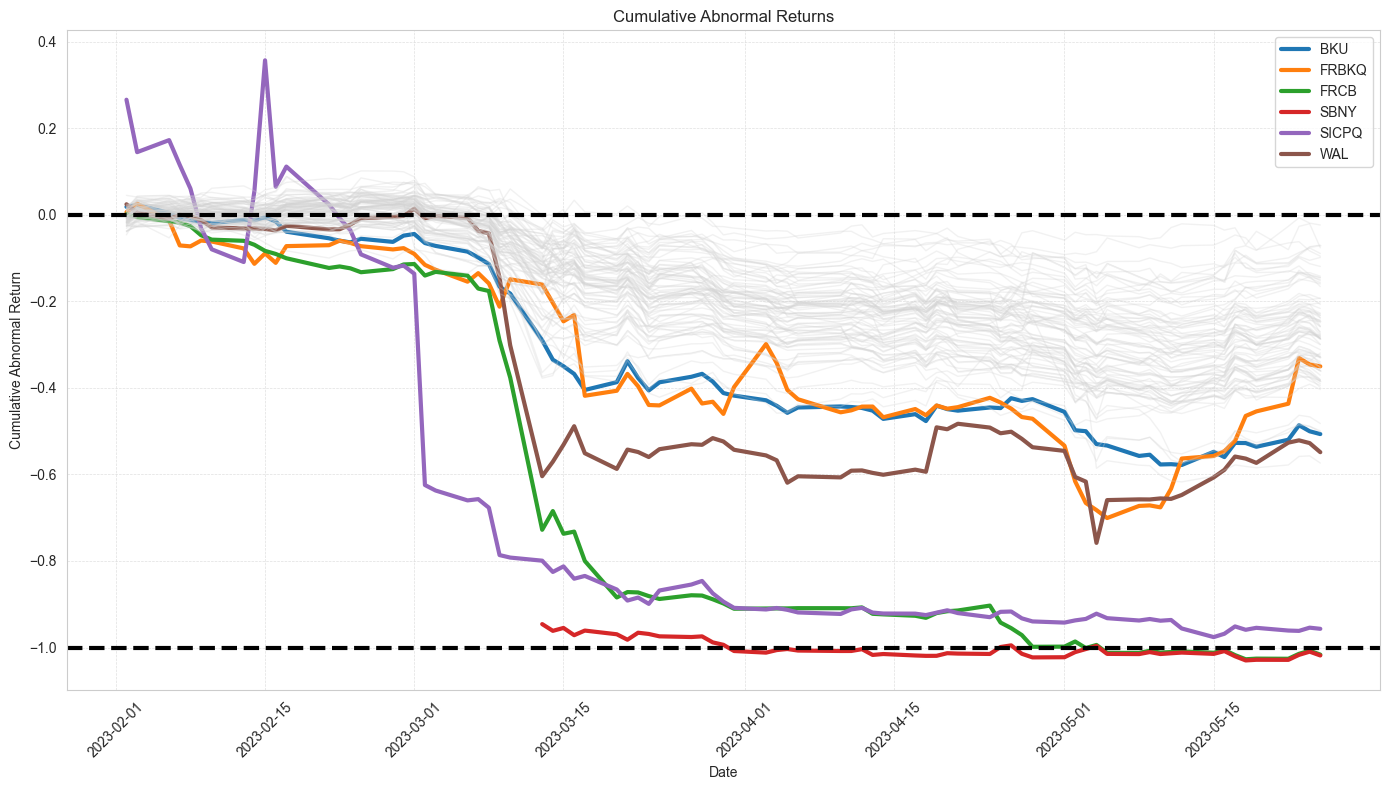

In [287]:
# use seaborn to plot the cumul_abonormal for 'FRCB' in a line plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
palette = sns.color_palette("Dark2", 3)


# Plot the cumulative abnormal return for 'FRCB', 'SBNY', 'SIVB', 'PACW', 'WAL', 'FFWM', 'BKU' and 'FRBK':
# Filter the data for the specified tickers
tickers_to_plot = ['FRCB', 'SBNY', 'SIVB', 'PACW', 'WAL', 'FFWM', 'BKU', 'FRBK', 'FRBKQ', 'SICPQ']
# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=returns_data_parsed[returns_data_parsed['ticker'].isin(tickers_to_plot)],
    x='Date',
    y='cumul_abnormal',
    hue='ticker',
    linewidth=3
)
plt.legend(frameon=False)  # turn off legend
# plot all the other tickers in gray:
other_tickers = returns_data_parsed['ticker'].unique()
other_tickers = [t for t in other_tickers if t not in tickers_to_plot]
for ticker in other_tickers:
    sns.lineplot(
        data=returns_data_parsed[returns_data_parsed['ticker'] == ticker],
        x='Date',
        y='cumul_abnormal',
        color='lightgray',
        linewidth=1,
        alpha=0.3
    )
# Dashed lines in 0 and -1:
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.axhline(-1, color='black', linestyle='--', linewidth=3)
plt.title("Cumulative Abnormal Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Abnormal Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
# turn of legend
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='lightgray')  # add grid
plt.show()

In [284]:
returns_data_parsed[returns_data_parsed['Date']=='2023-03-02'][['ticker','cumul_abnormal']].sort_values(by='cumul_abnormal',ascending=True)

,ticker,cumul_abnormal
5602,SICPQ,-0.624418
3495,FRCB,-0.140345
3416,FRBKQ,-0.115648
3021,FHN,-0.094211
98,ALLY,-0.084200
...,...,...
5523,SFBS,0.046587
2073,CFR,0.047860
888,BANF,0.049163
1678,CARE,0.064856


In [177]:
# ---------------------------------------------------------------------
# 19.  Excess-return window: 1 Feb 2022 → 31 Jan 2023
# ---------------------------------------------------------------------


cutoff_date = pd.Timestamp("2023-02-01")  # first day *excluded* from window
start_2022  = pd.Timestamp("2022-02-01")  # first day *included*

# ---------------------------------------------------------------------
# 19-A.  Market & bank-index series over the 2022 window 
# ---------------------------------------------------------------------

sp_data_parsed_2022 = (
    sp_data
      .sort_values("Date")
      .assign(daily_return_mkt=lambda df: df["close_prc"].pct_change())
      .loc[:, ["Date", "daily_return_mkt"]]
      .dropna()
      .merge(dowjonesbankindex, on="Date", how="left")
      .loc[lambda df: (df["Date"] > start_2022) & (df["Date"] < cutoff_date)]
      .assign(
          abnormal_bank_idx   = lambda df: df["daily_return_bankindex"]
                                            - df["daily_return_mkt"],
          cumul_mkt_ret       = lambda df: np.exp(np.log1p(
                                        df["daily_return_mkt"]).cumsum()) - 1,
          cumul_bankidx_ret   = lambda df: np.exp(np.log1p(
                                        df["daily_return_bankindex"]).cumsum()) - 1,
          cumul_abnormal_bankidx = lambda df: np.exp(np.log1p(
                                        df["daily_return_bankindex"]).cumsum()) - 1
      )
)

# -----------------------------------------------------------------
# 19-B. Bank-level returns, 1-Feb-22 → 31-Jan-23  (bug-free)
# -----------------------------------------------------------------

returns_data_parsed_2022 = (
    stock_data
      .merge(bank_sample[["tic"]].rename(columns={"tic": "ticker"}),
             on="ticker", how="inner")
      .merge(sp_data_parsed_2022, on="Date", how="left")          # ← only once
      .sort_values(["ticker", "Date"])
      .loc[lambda df: (df["Date"] >= start_2022) & (df["Date"] < cutoff_date)]
      # forward-fill missing closes
      .groupby("ticker", group_keys=False)
          .apply(lambda g: g.assign(close_prc=g["close_prc"].ffill()))
      # daily return; skip first day
      .assign(daily_return=lambda df: df["close_prc"].pct_change())\
          .loc[lambda df: df["Date"] != start_2022]\
          .fillna({"daily_return": 0})
      # abnormal = bank − market
      .assign(abnormal=lambda df: df["daily_return"] - df["daily_return_mkt"])
      # cumulative by ticker
      .groupby("ticker", group_keys=False)
          .apply(lambda g: g.assign(
              cumul_ret      = np.exp(np.log1p(g["daily_return"]).cumsum()) - 1,
              cumul_abnormal = np.exp(np.log1p(g["abnormal"]).cumsum()) - 1
          ))
      # excess over market cumulative
      .assign(cumul_abnormal=lambda df: df["cumul_ret"] - df["cumul_mkt_ret"])
      .reset_index(drop=True)
)

# -----------------------------------------------------------------
# 19-C.  Asset-weighted & equal-weighted sample return
# -----------------------------------------------------------------
sample_bank_return_2022 = (
    returns_data_parsed_2022
      .merge(                                  # bring in the weights
          final_bank_data[["tic", "assets_imp"]]
            .rename(columns={"tic": "ticker"}),
          on="ticker", how="left"
      )
      .assign(assets_imp=lambda df: pd.to_numeric(df["assets_imp"],
                                                 errors="coerce"))
      # one row per Date with both weighted and un-weighted mean
      .groupby("Date", as_index=False)
      .apply(
          lambda g: pd.Series({
              "cumul_ret":      np.average(g["cumul_ret"],
                                           weights=g["assets_imp"]),
              "cumul_ret_unw":  g["cumul_ret"].mean()
          })
      )
      .reset_index(drop=True)
)


C:\Users\angel\AppData\Local\Temp\ipykernel_8012\891351429.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(close_prc=g["close_prc"].ffill()))
C:\Users\angel\AppData\Local\Temp\ipykernel_8012\891351429.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(
C:\Users\angel\AppData\Local\Temp\ipykernel_8012\891351429.py:78: DeprecationWarning: DataFrameGro

In [179]:
# ------------------------------------------------------------------
# 20.  CAPM beta and “bank-index” beta, skipping empty groups
# ------------------------------------------------------------------

import statsmodels.api as sm

df22 = returns_data_parsed_2022[
    returns_data_parsed_2022["Date"].dt.year == 2022
]

# ── 20-A.  plain CAPM beta  β_mkt  ----------------------------------------
rows = []
for tkr, g in df22.groupby("ticker"):
    g = g.dropna(subset=["daily_return", "daily_return_mkt"])
    if len(g) < 5:          # require at least 5 valid observations
        rows.append({"ticker": tkr, "beta": np.nan})
        continue

    beta = sm.OLS(g["daily_return"],
                  sm.add_constant(g["daily_return_mkt"])).fit()\
                 .params["daily_return_mkt"]
    rows.append({"ticker": tkr, "beta": beta})

ticker_betas = pd.DataFrame(rows)

# ── 20-B.  bank-index beta  β_bank  ---------------------------------------
rows = []
for tkr, g in df22.groupby("ticker"):
    g = g.dropna(subset=["daily_return",
                         "daily_return_mkt",
                         "abnormal_bank_idx"])
    if len(g) < 5:
        rows.append({"ticker": tkr, "beta_bank": np.nan})
        continue

    res = sm.OLS(g["daily_return"],
                 sm.add_constant(g[["daily_return_mkt",
                                    "abnormal_bank_idx"]]))\
            .fit()

    rows.append({
        "ticker":     tkr,
        "beta_bank":  res.params["abnormal_bank_idx"],
        # "beta_bank_se": np.sqrt(
        #        res.cov_params().loc["abnormal_bank_idx",
        #                            "abnormal_bank_idx"])
    })

ticker_bankbetas = pd.DataFrame(rows)

# Results:  ticker_betas  (ticker | beta)
#           ticker_bankbetas  (ticker | beta_bank)


In [184]:
# -------------------------------------------------------------------
# 21.  Attach betas, build CAPM–abnormal returns, pull key snapshots
# -------------------------------------------------------------------

early_date = pd.Timestamp("2023-03-17")   # from date_list[0]
late_date  = pd.Timestamp("2023-05-25")   # from date_list[1]

# ── 21-A. add betas + abnormal-CAPM to the full panel ────────────────
returns_data_parsed = (
    returns_data_parsed
      .merge(ticker_betas,     on="ticker", how="left")
      .merge(ticker_bankbetas, on="ticker", how="left")
      .assign(
          abnormal_capm = lambda df:
              df["daily_return"] - df["beta"]*df["daily_return_mkt"]
      )
      # cumulative abnormal CAPM, by ticker
      .groupby("ticker", group_keys=False)
          .apply(lambda g:
              g.assign(cumul_abnormal_capm =
                       np.exp(np.log1p(g["abnormal_capm"]).cumsum()) - 1)
          )
)

# same calculation, but only from 15-Feb-23 forward
returns_data_parsed_feb15 = (
    returns_data_parsed
      .loc[lambda df: df["Date"] >= pd.Timestamp("2023-02-15")]
      .copy()
)

# ── 21-B.  Convenience snapshots --------------------------------------

# 03-Mar-23 to 30-Apr-23 window, keep rows on the two report dates
mask_multi = (
    (returns_data_parsed["Date"] >= pd.Timestamp("2023-03-03")) &
    (returns_data_parsed["Date"] <= pd.Timestamp("2023-04-30")) &
    (returns_data_parsed["Date"].isin([early_date, late_date]))
)
bank_cumul_ret_multiple = (
    returns_data_parsed.loc[mask_multi]
      .sort_values("cumul_abnormal")
)

# single-day slices
bank_cumul_ret_early = (
    returns_data_parsed
      .loc[returns_data_parsed["Date"] == early_date]
      .sort_values("cumul_abnormal")
)

bank_cumul_ret_short = (
    returns_data_parsed
      .loc[returns_data_parsed["Date"] == pd.Timestamp("2023-03-10")]
      .sort_values("cumul_abnormal")
)

bank_cumul_ret = (
    returns_data_parsed
      .loc[returns_data_parsed["Date"] == late_date]
      .sort_values("cumul_abnormal")
)

# ── 21-C.  End-of-2022 cumulative abnormal return --------------------
bank_cumul_ret_2022 = (
    returns_data_parsed_2022
      .groupby("ticker", as_index=False)
      .apply(lambda g: g.loc[g["Date"].idxmax()])        # last obs in 2022
      .sort_values("cumul_abnormal")
      .reset_index(drop=True)
)

# objects produced:
#   • returns_data_parsed_feb15
#   • returns_data_parsed        (now with beta & cumul_abnormal_capm)
#   • bank_cumul_ret_multiple    (early & late dates in Mar-Apr window)
#   • bank_cumul_ret_early       (17-Mar-23)
#   • bank_cumul_ret_short       (10-Mar-23)
#   • bank_cumul_ret             (25-May-23)
#   • bank_cumul_ret_2022        (ticker-level last obs of 2022 window)


C:\Users\angel\AppData\Local\Temp\ipykernel_8012\3174267033.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g:
C:\Users\angel\AppData\Local\Temp\ipykernel_8012\3174267033.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g["Date"].idxmax()])        # last obs in 2022
